# Scenarios Data Analysis

In [1]:
# Load scenarios

%matplotlib inline

from collections import Counter, defaultdict
import gzip
import json
import math
from operator import itemgetter
from pathlib import Path

from IPython.display import display, Markdown
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from pygtrie import StringTrie
import seaborn as sns

SCENARIO_DIR = Path("../scenarios")

rpc_calls = defaultdict(list)
scenario_configs = {}

for scenario in SCENARIO_DIR.glob("*.gz"):
    name = scenario.name.split("_")[0]
    with gzip.open(scenario) as f:
        for i, line in enumerate(f.readlines()):
            item = json.loads(line)
            if i == 0:
                scenario_configs[name] = item
            else:
                rpc_calls[name].append(item)

In [2]:
config_data = defaultdict(list)
for scenario in sorted(scenario_configs.keys()):
    config_data["scenario"].append(scenario)
    config_data["logger_enabled"].append(scenario_configs[scenario]["logger_enabled"])
    provider_conf = scenario_configs[scenario]["provider_config"]
    config_data["hardfork"].append(provider_conf["hardfork"])
    config_data["forking"].append(provider_conf["fork"] is not None)
    config_data["auto_mining"].append(provider_conf["mining"]["auto_mine"])
    config_data["interval_mining"].append(provider_conf["mining"]["interval"] is not None)

df = pd.DataFrame(config_data)
Markdown("## Provider Configs")
display(df)

,scenario,logger_enabled,hardfork,forking,auto_mining,interval_mining
0,neptune-mutual-blue-protocol,False,SHANGHAI,False,True,False
1,openzeppelin-contracts,False,SHANGHAI,False,True,False
2,rocketpool,False,SHANGHAI,False,True,False
3,safe-contracts,False,SHANGHAI,False,True,False
4,seaport,False,SHANGHAI,False,True,False
5,synthetix,False,SHANGHAI,False,True,False
6,uniswap-v3-core,False,SHANGHAI,False,True,False


The table above shows the provider config for each scenario. No scenario has the logger enabled since they were collected with the in process provider. All scenarios use the Shanghai hardfork which makes sense since it's the latest. No scenario uses fork mode or interval mining which questions the representativeness of the dataset.

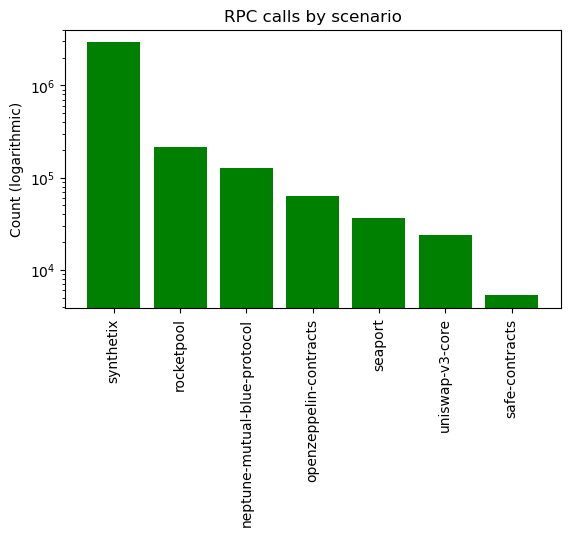

,scenario,rpc_call_count
0,synthetix,2920383
1,rocketpool,215846
2,neptune-mutual-blue-protocol,125637
3,openzeppelin-contracts,62857
4,seaport,36035
5,uniswap-v3-core,23853
6,safe-contracts,5272


In [3]:
rpc_call_counts = {key: len(value) for key, value in rpc_calls.items()}
rpc_call_counts = list(zip(*sorted(rpc_call_counts.items(), key=lambda item: item[1], reverse=True)))

plt.bar(rpc_call_counts[0], rpc_call_counts[1], color='g')
plt.title('RPC calls by scenario')
plt.ylabel('Count (logarithmic)')
plt.gca().set_yscale('log')
plt.xticks(rotation='vertical')
plt.subplots_adjust(bottom=0.3)
plt.show()

df = pd.DataFrame({"scenario": rpc_call_counts[0], "rpc_call_count": rpc_call_counts[1]})
display(df)

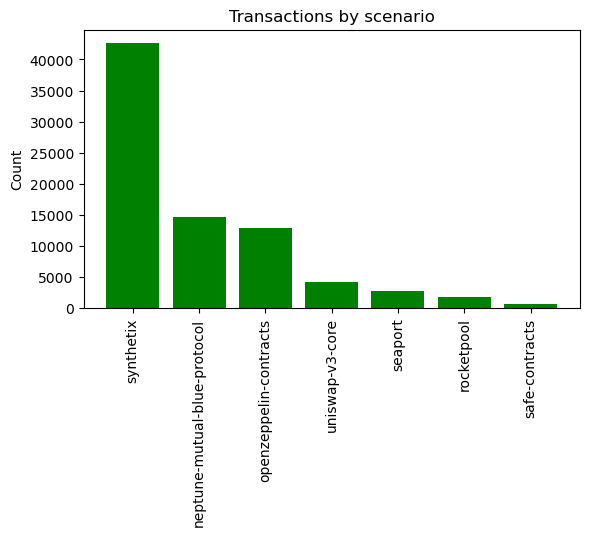

,scenario,transaction_count
0,synthetix,42643
1,neptune-mutual-blue-protocol,14629
2,openzeppelin-contracts,12859
3,uniswap-v3-core,4199
4,seaport,2828
5,rocketpool,1854
6,safe-contracts,632


In [4]:
transactions = defaultdict(list)
for name, calls in rpc_calls.items():
    for item in calls:
        if "send" in item["method"] and "Transaction" in item["method"]:
            transactions[name].append(item) 

transaction_counts = {key: len(value) for key, value in transactions.items()}
transaction_counts = list(zip(*sorted(transaction_counts.items(), key=lambda item: item[1], reverse=True)))

plt.bar(transaction_counts[0], transaction_counts[1], color='g')
plt.title('Transactions by scenario')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.subplots_adjust(bottom=0.3)

plt.show()

df = pd.DataFrame({"scenario": transaction_counts[0], "transaction_count": transaction_counts[1]})
display(df)

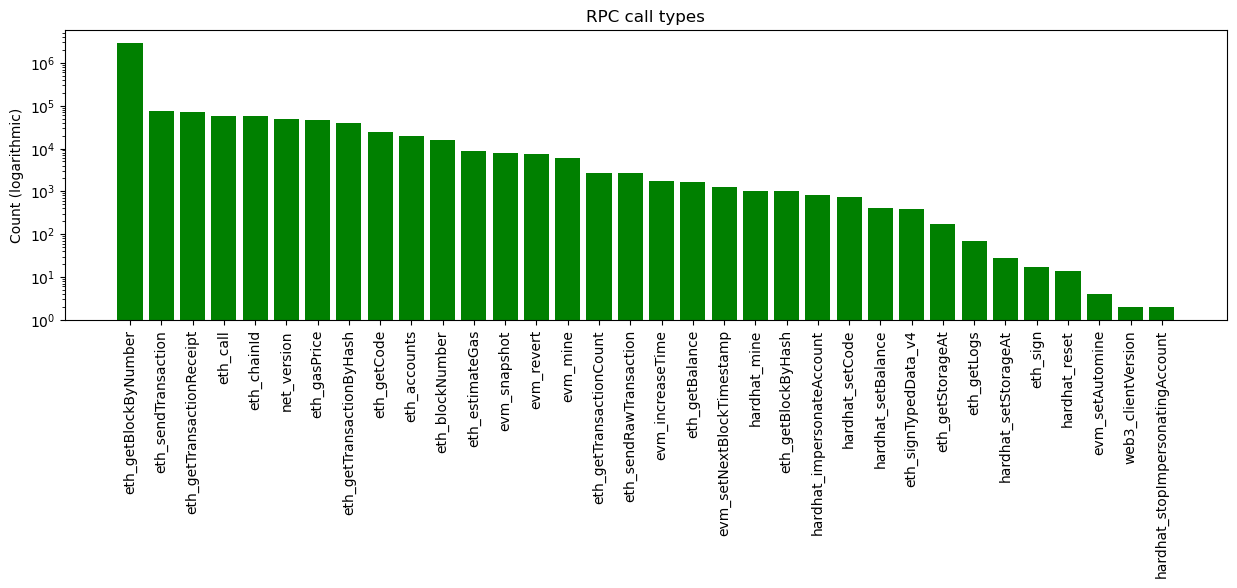

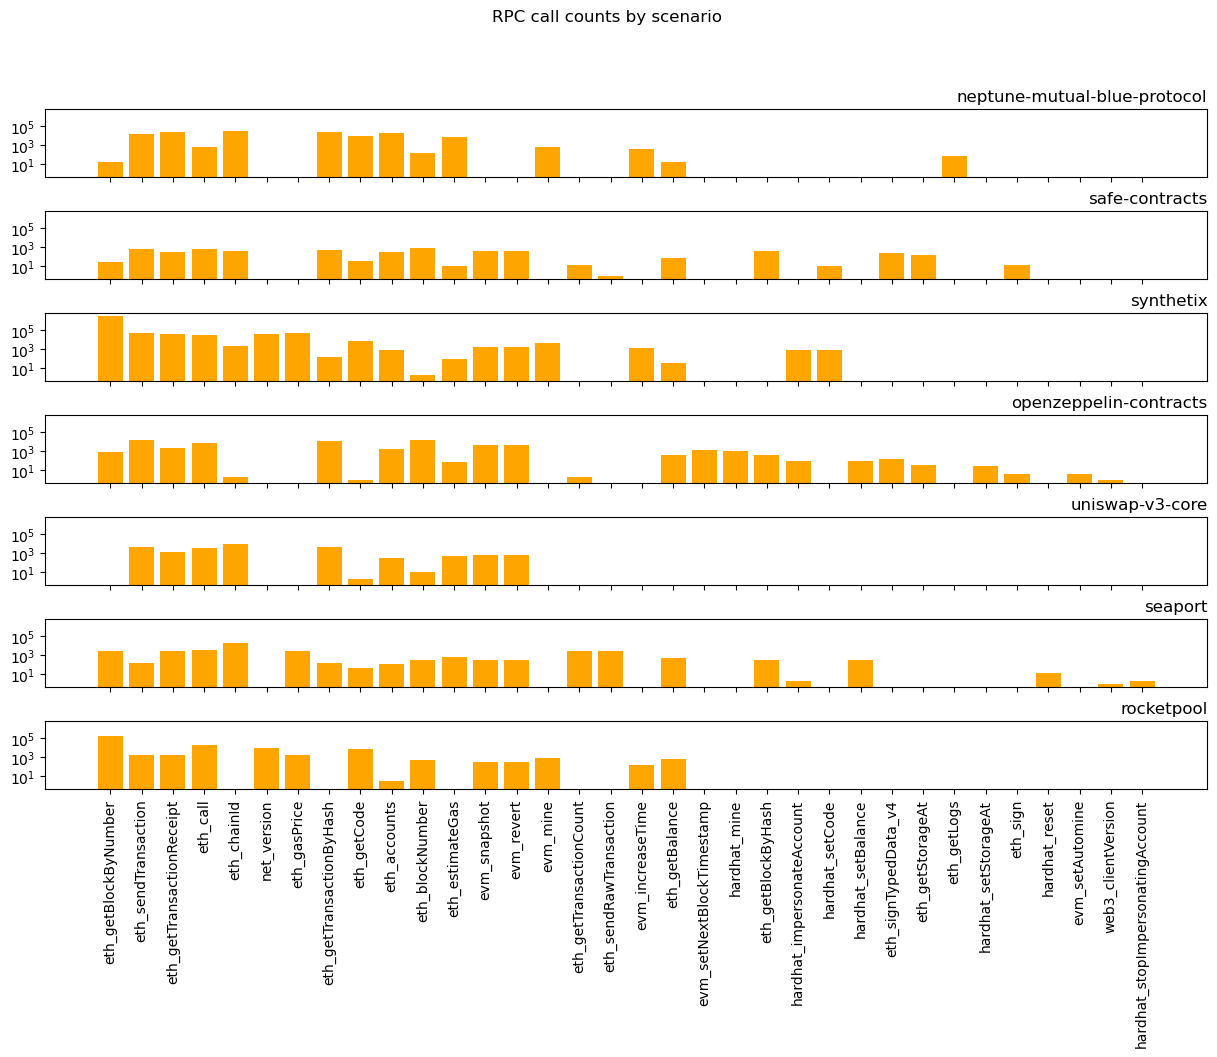

In [5]:
rpc_call_types = defaultdict(lambda: defaultdict(int))
rpc_call_types_total = defaultdict(int)
for scenario, calls in rpc_calls.items():
    for item in calls:
        method = item["method"]
        rpc_call_types[scenario][method] += 1
        rpc_call_types_total[method] += 1

rpc_calls_by_count = list(map(lambda item: item[0], sorted(rpc_call_types_total.items(), key=lambda item: item[1], reverse=True)))

rpc_call_types_total = list(zip(*sorted(rpc_call_types_total.items(), key=lambda item: item[1], reverse=True)))

plt.figure(figsize=(15, 5))
plt.bar(rpc_call_types_total[0], rpc_call_types_total[1], color='g')
plt.title('RPC call types')
plt.ylabel('Count (logarithmic)')
plt.gca().set_yscale('log')
plt.xticks(rotation='vertical')
plt.subplots_adjust(bottom=0.3)
plt.show()

fig, axs = plt.subplots(len(rpc_call_types), 1, sharex=True, sharey=True, figsize=(15, 10))
fig.suptitle('RPC call counts by scenario')
plt.subplots_adjust(hspace=0.5)
plt.xticks(rotation='vertical')
plt.subplots_adjust(bottom=0.2)

for ax, (scenario, counts) in zip(axs, rpc_call_types.items()):
    ys = [counts.get(method, 0) for method in rpc_calls_by_count]
    ax.bar(rpc_calls_by_count, ys, color='orange')
    ax.set_yscale('log')
    y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
    ax.yaxis.set_major_locator(y_major)
    ax.set_title(scenario, loc='right')

plt.show()

### `eth_getBlockByNumber`

The high number of `eth_getBlockByNumber` calls is concerning. In aggregate, the various scenarios call `eth_getBlockByNumber` 10x more than `eth_sendTransaction` while there should be no reason to get more blocks than there are transactions. In `rocketpool` and `synthetix` the multiplier is 100x which points to a bug in a plugin used by these repos.

The overhead from `eth_getBlockByNumber` is twofold: 
1. While fetching already mined blocks is cheap in Rust, serializing them to string and then parsing on the JS side is not.
2. The plugins probably do some extra processing of the blocks which might be expensive.

### Automining

Only the `openzeppelin` repo turns off automining and only briefly, so it's worth optimizing for automining which we know that it's currently slow due to making snapshots before each automined block.

### `eth_estimateGas`

It's interesting to see that `eth_estimateGas` usage varies between scenarios. Most scenarios use `eth_estimateGas` for a fraction of the transactions, while `rocketpool` doesn't use it all and `neptune-mutual` seems to use it for all transactions.

### Cacheable getters

There is a high number of `eth_chainId`, `net_version` and `eth_accounts` calls. These should be cacheable for the lifetime of a provider. The performance impact is unclear.

### `hardhat_reset`

Only `seaport` is using `hardhat_reset` out of the 7 scenarios, so it's not worth spending time on optimizing this method.


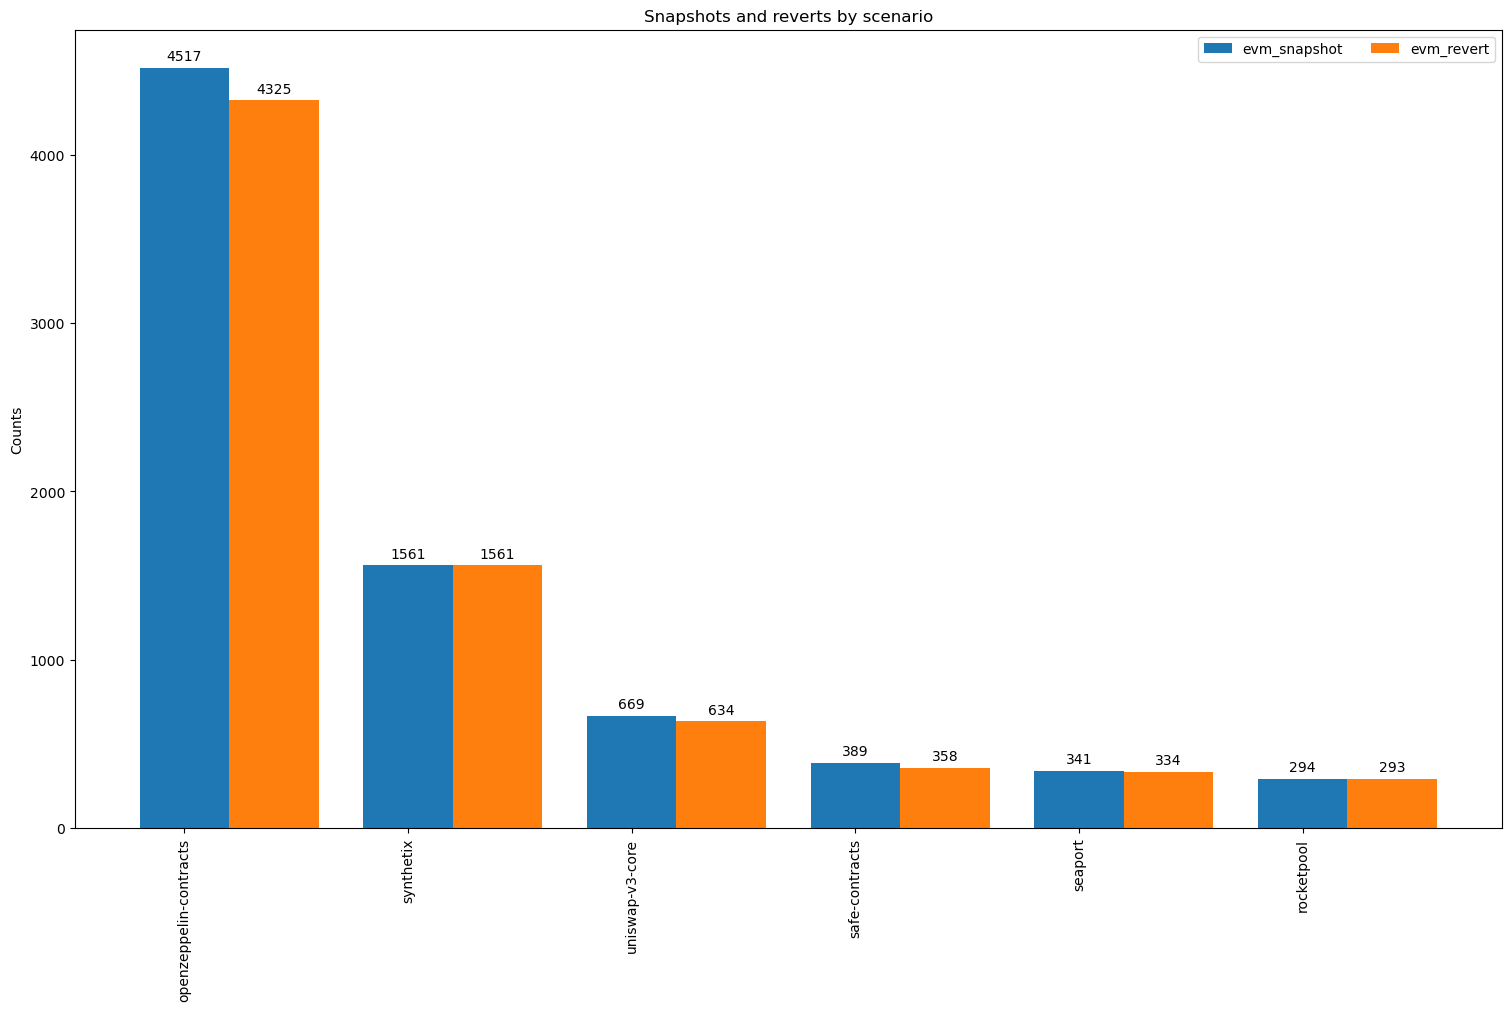

In [6]:
revert_methods = ["evm_snapshot", "evm_revert"]

snapshots_and_reverts = defaultdict(lambda: defaultdict(int))
for scenario, calls in rpc_calls.items():
    for item in calls:
        method = item["method"]
        if method in revert_methods:
            snapshots_and_reverts[scenario][method] += 1

scenarios_by_snapshots = list(map(lambda item: item[0], sorted(snapshots_and_reverts.items(), key=lambda item: item[1]["evm_snapshot"], reverse=True)))

fig, ax = plt.subplots(layout='constrained', figsize=(15, 10))

x = np.arange(len(snapshots_and_reverts))
width = 0.4
multiplier = 1
for method in revert_methods:
    offset = width * multiplier
    bars = [snapshots_and_reverts[s][method] for s in scenarios_by_snapshots]
    rects = ax.bar(x + offset, bars, width, label=method)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Snapshots and reverts by scenario')
ax.set_xticks(x + width, scenarios_by_snapshots, rotation='vertical')
ax.legend(loc='upper right', ncols=3)

plt.show()

It's interesting to see that while `synthetix` has almost 3 times as many transactions as `openzeppelin`, the latter does more than 10x snapshots. Note that `neptune-mutual-blue-protocol` creates no snapshots.

### Revert depths by scenario

The revert depth is the difference between the latest snapshot id and the snapshot id that was reverted to (`seaport` is excluded from the plot since it's an outlier).

revert_depth                                           \
                              count        mean         std  min  25%    50%   
scenario                                                                       
openzeppelin-contracts       4325.0    2.758150    2.933468  0.0  1.0    2.0   
rocketpool                    293.0    9.808874   29.863233  0.0  1.0    3.0   
safe-contracts                358.0    3.877095   12.407935  0.0  1.0    1.0   
seaport                       334.0  983.934132  799.327883  3.0  8.0  959.5   
synthetix                    1561.0   14.950673   26.343018  0.0  3.0    8.0   
uniswap-v3-core               634.0    5.294953    4.139328  0.0  4.0    4.0   

                                        
                           75%     max  
scenario                                
openzeppelin-contracts     5.0    66.0  
rocketpool                 6.0   351.0  
safe-contracts             2.0   146.0  
seaport                 1569.0  3136.0  
synthetix                 19.0   329.0  
uniswap-v3-core            7.0    54.0

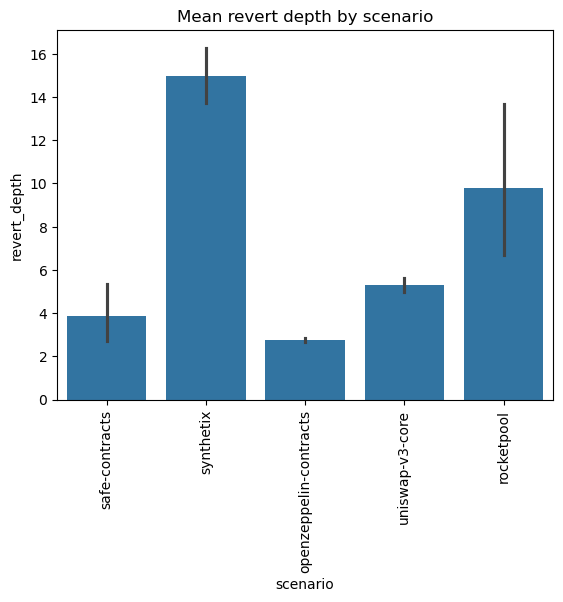

In [15]:
reverts = defaultdict(list)
for scenario, calls in rpc_calls.items():
    automining = scenario_configs[scenario]["provider_config"]["mining"]["auto_mine"]
    # Snapshot ids start at one
    snapshot_id = 0
    automine_count = 0
    for item in calls:
        method = item["method"]
        if method == "evm_setAutomine":
            automining = item["params"][0]
        elif automining and ("sendTransaction" in method or "sendRaw" in method):
            # EDR currently automatically snapshots when automining
            automine_count += 1
        elif method == "evm_snapshot":
            snapshot_id += 1
        elif method == "evm_revert":
            reverts["scenario"].append(scenario)
            revert_id = int(item["params"][0], 0)
            # Correct by removing the automine count from the snapshot id to revert to
            reverts["revert_depth"].append(snapshot_id  - (revert_id - automine_count))

display(Markdown("### Revert depths by scenario"))
display(Markdown("The revert depth is the difference between the latest snapshot id and the snapshot id that was reverted to (`seaport` is excluded from the plot since it's an outlier)."))

df = pd.DataFrame(reverts)
display(df.groupby("scenario").describe())

ax = sns.barplot(x="scenario", y="revert_depth", data=df.drop(df.index[df["scenario"] == "seaport"]))
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Mean revert depth by scenario")

The variations are too large to introduce optimizations based on a max assumed revert depth.

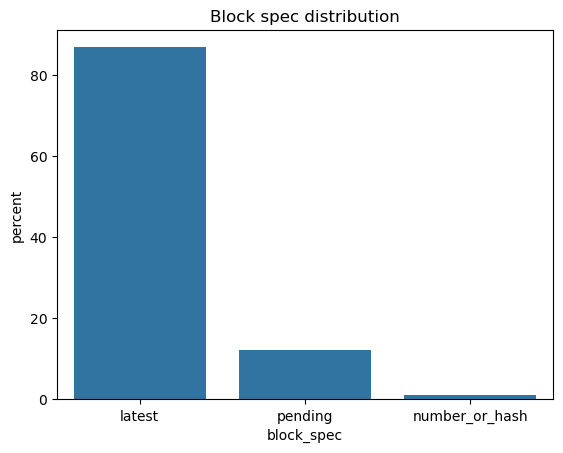

In [8]:
block_specs = defaultdict(list)

context_methods = {"eth_getBalance", "eth_estimateGas", "eth_getCode", "eth_getStorageAt", "eth_getTransactionCount"}
# The block spec argument is somewhat convoluted for these methods and they aren't used in the scenarios so these aren't support yet.
unsupported_context_methods = {"debug_traceTransaction", "debug_traceCall"}

for scenario, calls in rpc_calls.items():
    for item in calls:
        method = item["method"]
        if method in context_methods:
            block_spec = item["params"][-1]
        elif method == "eth_call":
            block_spec = item["params"][1]
        elif method in unsupported_context_methods:
            raise NotImplementedError
        else:
            continue

        if isinstance(block_spec, bool):
            print(item)

        if block_spec is None:
            block_spec = "latest"

        if block_spec.startswith("0x"):
            block_spec = "number_or_hash"

        block_specs["scenario"].append(scenario)
        block_specs["method"].append(method)
        block_specs["block_spec"].append(block_spec)

df = pd.DataFrame(block_specs)
ax = sns.countplot(df, x="block_spec", stat="percent")
_ = ax.set_title("Block spec distribution")

The block spec distribution heavily favors the latest block.

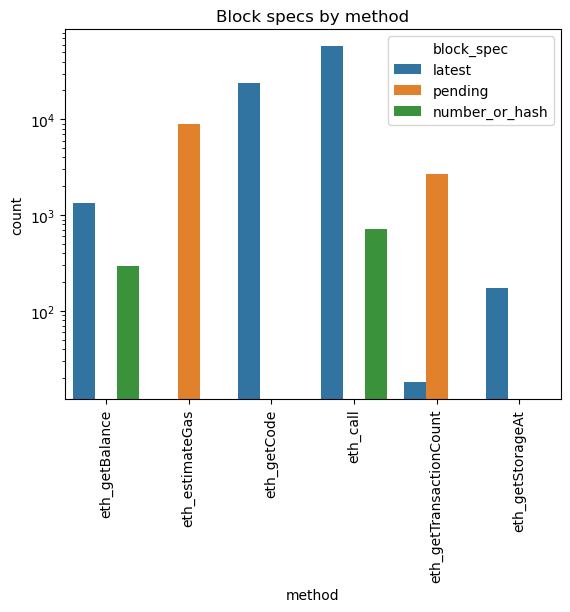

In [9]:
ax = sns.countplot(df, x="method", hue="block_spec")
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Block specs by method")

The `pending` block spec seems to be only used with `eth_estimateGas` and `eth_getTransactionCount`. It might be worth introducing specific optimizations for these methods with the `pending` block spec. 

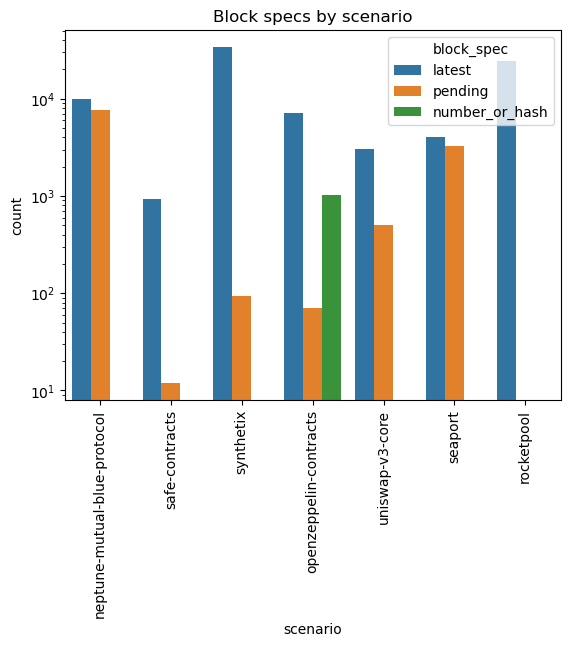

In [10]:
ax = sns.countplot(df, x="scenario", hue="block_spec")
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Block specs by scenario")

It's interesting to see that we've seen the largest [performance gains](https://github.com/NomicFoundation/edr/issues/33) in `rocketpool` and `safe-contracts` which barely use the `pending` block spec.

In [11]:
# These methods add a lot of noise
ignored_methods = {"eth_getBlockByNumber", "eth_chainId", "net_version", "eth_accounts"}

rpc_methods = defaultdict(list)
for scenario, calls in rpc_calls.items():
    for call in calls:
        method = call["method"]
        if method not in ignored_methods:
            rpc_methods[scenario].append(call["method"])

pattern_data = defaultdict(list)
for scenario, methods in rpc_methods.items():
    for n in range(15, 1, -1):
        ngrams = list(nltk.ngrams(methods, n))
        most_common = Counter(ngrams).most_common(100)
        for (pattern, count) in most_common:
            pattern = " ".join(pattern)
            pattern = pattern.replace("eth_", "")
            pattern = pattern.replace("Transaction", "Tx")
            pattern_data["pattern"].append(pattern)
            pattern_data["ratio"].append(count / len(ngrams))
            pattern_data["scenario"].append(scenario)
            i += 1

df_original = pd.DataFrame(pattern_data)
df_grouped = df_original.groupby("pattern").aggregate({"ratio": "sum", "scenario": "count"})
# Only keep patterns that are present in at least two scenarios 
df_grouped = df_grouped[df_grouped["scenario"] > 2]
df_grouped = df_grouped.reset_index()

trie = StringTrie(separator=" ")
for p in sorted(df_grouped["pattern"].to_list(), key=lambda p: p.count(" "), reverse=True):
    if trie.has_subtrie(p):
        continue
    else:
        trie[p] = p

# Remove patterns that are prefixes of longer patterns
mask = df_grouped["pattern"].apply(lambda p: trie.has_key(p))
df_grouped = df_grouped[mask]

display(Markdown("## Patterns"))
display(Markdown("Most frequent patterns and the number of scenarios that they appear in."))
display(df_grouped.sort_values(["ratio", "scenario"], ascending=[False, False])[:25].drop("ratio", axis=1).style.hide(axis="index"))


## Patterns

Most frequent patterns and the number of scenarios that they appear in.

pattern,scenario
sendTx getTxReceipt,3
blockNumber sendTx getTxByHash,3
getTxReceipt gasPrice,3
getTxByHash sendTx getTxByHash,3
call getCode,3
getTxByHash blockNumber sendTx,3
sendTx getTxByHash blockNumber,3
call call call call call call call call call call call call call call call,5
getTxByHash getCode,4
getTxByHash estimateGas sendTx,4


## Conclusion

The highest impact optimization based on the data analysis seems to be avoiding state snapshot when automining since almost all transactions are executed in automine mode.